### Librerías

In [1]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import MinMaxScaler

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

### Llamado Dataset

In [2]:
# Obtener el directorio actual de trabajo
directorio_actual = os.getcwd()

# Especificar la ruta relativa desde el directorio actual
ruta_csv_relativa = os.path.join('..', 'data', '01_raw','spotify.csv')

# Cargar el archivo CSV
spotify = pd.read_csv(ruta_csv_relativa)

# Mostrar las primeras filas del DataFrame
spotify.head(10)

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,acoustic
5,5,01MVOl9KtVTNfFiBU9I7dc,Tyrone Wells,Days I Will Remember,Days I Will Remember,58,214240,False,0.688,0.4810,...,-8.807,1,0.1050,0.2890,0.000000,0.1890,0.6660,98.017,4,acoustic
6,6,6Vc5wAMmXdKIAM7WUoEb7N,A Great Big World;Christina Aguilera,Is There Anybody Out There?,Say Something,74,229400,False,0.407,0.1470,...,-8.822,1,0.0355,0.8570,0.000003,0.0913,0.0765,141.284,3,acoustic
7,7,1EzrEOXmMH3G43AXT1y7pA,Jason Mraz,We Sing. We Dance. We Steal Things.,I'm Yours,80,242946,False,0.703,0.4440,...,-9.331,1,0.0417,0.5590,0.000000,0.0973,0.7120,150.960,4,acoustic
8,8,0IktbUcnAGrvD03AWnz3Q8,Jason Mraz;Colbie Caillat,We Sing. We Dance. We Steal Things.,Lucky,74,189613,False,0.625,0.4140,...,-8.700,1,0.0369,0.2940,0.000000,0.1510,0.6690,130.088,4,acoustic
9,9,7k9GuJYLp2AzqokyEdwEw2,Ross Copperman,Hunger,Hunger,56,205594,False,0.442,0.6320,...,-6.770,1,0.0295,0.4260,0.004190,0.0735,0.1960,78.899,4,acoustic


## Escalado de datos

Este escalado de variables es para poder trabajar con los modelos en un futuro

### duration_ms Scaler

### population Scaler

In [3]:
from sklearn.preprocessing import StandardScaler

# Crear un objeto StandardScaler
scaler = MinMaxScaler()

# Seleccionar solo la columna de popularidad para escalar
spotify['popularity_scaled'] = scaler.fit_transform(spotify[['popularity']])

# Mostrar las primeras filas para verificar
spotify[['popularity', 'popularity_scaled']].head()


,popularity,popularity_scaled
0,73,0.73
1,55,0.55
2,57,0.57
3,71,0.71
4,82,0.82


### Group feature Scaler

In [4]:
from sklearn.preprocessing import MinMaxScaler

# Seleccionar las características numéricas para escalar
features_to_scale = ['danceability', 'energy', 'loudness', 'speechiness', 
                     'acousticness', 'instrumentalness', 'liveness', 
                     'valence', 'tempo']

scaler = MinMaxScaler()
spotify[features_to_scale] = scaler.fit_transform(spotify[features_to_scale])

print('Caracteristicas escaladas: ', features_to_scale)

Caracteristicas escaladas:  ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']


## Creación de nuevas característica

### duration_ms a tiempo_ms_seconds

La duración_ms se calculo para que los valores de milisegundos se pasen a minutos y segundos

In [5]:
# Convertir milisegundos a segundos
spotify['tiempo_ms_seconds'] = spotify['duration_ms'] / 1000

# Función para convertir segundos a formato de minutos y segundos
def segundos_a_formato(segundos):
    minutos = int(segundos // 60)
    segundos_restantes = int(segundos % 60)
    return f"{minutos} minuto{'s' if minutos != 1 else ''} con {segundos_restantes} segundo{'s' if segundos_restantes != 1 else ''}"

# Aplicar la función a la columna de segundos
spotify['duration_ms_scaled'] = spotify['tiempo_ms_seconds'].apply(segundos_a_formato)

# Mostrar los primeros 10 valores formateados
print(spotify['duration_ms_scaled'].head(10))


0    3 minutos con 50 segundos
1    2 minutos con 29 segundos
2    3 minutos con 30 segundos
3    3 minutos con 21 segundos
4    3 minutos con 18 segundos
5    3 minutos con 34 segundos
6    3 minutos con 49 segundos
7     4 minutos con 2 segundos
8     3 minutos con 9 segundos
9    3 minutos con 25 segundos
Name: duration_ms_scaled, dtype: object


### tranck_genre a Label Encoding

Cambiar la etiqueta categórica de track_genre a un valor numérico.

In [6]:
from sklearn.preprocessing import LabelEncoder

# Crear el codificador de etiquetas
le = LabelEncoder()

# Aplicar Label Encoding a la columna 'track_genre'
spotify['track_genre_encoded'] = le.fit_transform(spotify['track_genre'])

# Ver las primeras filas para verificar la codificación
print(spotify[['track_genre', 'track_genre_encoded']].head())


  track_genre  track_genre_encoded
0    acoustic                    0
1    acoustic                    0
2    acoustic                    0
3    acoustic                    0
4    acoustic                    0


### Nueva variable "Intensity"

Al tener una buena correlación gracias a la matriz, decidimos optar por juntar la energy con la danceability

In [7]:
# Crear una nueva columna de "intensidad"
spotify['intensity'] = spotify['energy'] * spotify['danceability']

spotify['intensity'].head(10)

0    0.316382
1    0.070782
2    0.159637
3    0.016095
4    0.277943
5    0.335968
6    0.060740
7    0.316885
8    0.262690
9    0.283598
Name: intensity, dtype: float64

## Eliminación de característica

Se elimino. 

Unnamed : 0 - artitst - album_name - track_id - track_name - explicit - time_signature - mode - duration_ms - log_duration_ms

## Correlation Matrix

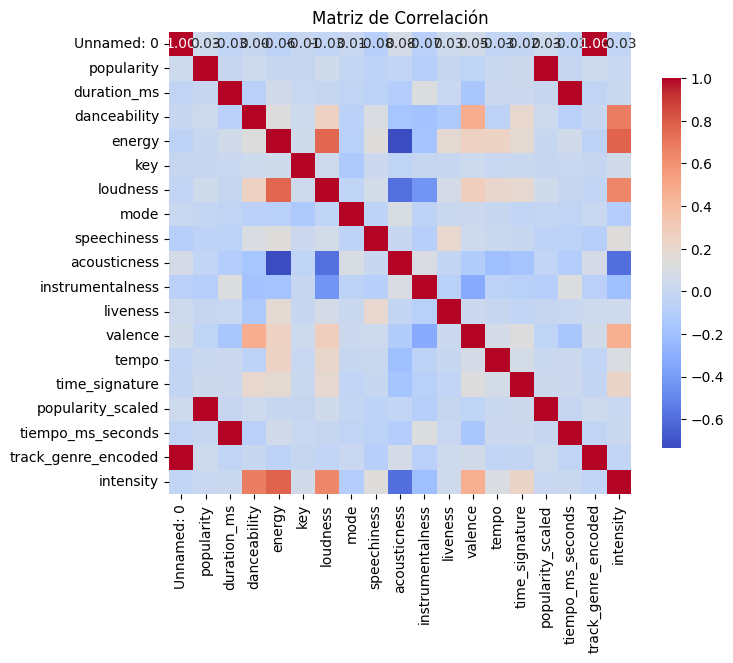

In [8]:
# Selección de Datos Numéricos
datosNumericos = spotify.select_dtypes(include=[np.number])

# Calcular la matriz de correlación
matriz_correlacion = datosNumericos.corr()

# Mostrar la matriz de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_correlacion, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={'shrink': .8})
plt.title('Matriz de Correlación')
plt.show()

## Exploración nuevo DataSet "spotify"

### Información del DataSet

In [9]:
spotify.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 26 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Unnamed: 0           114000 non-null  int64  
 1   track_id             114000 non-null  object 
 2   artists              113999 non-null  object 
 3   album_name           113999 non-null  object 
 4   track_name           113999 non-null  object 
 5   popularity           114000 non-null  int64  
 6   duration_ms          114000 non-null  int64  
 7   explicit             114000 non-null  bool   
 8   danceability         114000 non-null  float64
 9   energy               114000 non-null  float64
 10  key                  114000 non-null  int64  
 11  loudness             114000 non-null  float64
 12  mode                 114000 non-null  int64  
 13  speechiness          114000 non-null  float64
 14  acousticness         114000 non-null  float64
 15  instrumentalness 

### Cantidad total de datos

In [10]:
spotify.dtypes.value_counts()

float64    12
int64       7
object      6
bool        1
Name: count, dtype: int64

# Futuro

El objetivo de este proyecto es desarrrollar un sistema de recomendación de música. Específicamente usando K-Means y K-Vecinos más cercanos (K-NN). Hemos utilizado el procedimiento previo para preparar el conjunto de datos. 

- Escalado de variables: La mayoría de las variables numéricas han sido escaladas. Para asegurar que todas las características sean similares.

- Eliminación de variables categóricas: Las variables categóricas se han eliminado o transformado con el método de Label Encoding, para evitar problemas con los algoritmos que no puedan procesar ese tipo de dato.

El sistema de recomendación funcionará agrupando canciones similares (K-Means) o sugiriendo canciones basadas a las características (K-NN). De esta forma se busca que el sistema pueda recomendar canciones que se alineen con el gusto del usuario.

Cabe recalcar que el método para lograr el objetivo puede cambiar al avanzar con el desarrollo y evaluación de los modelos. Nuestra intención es buscar el mejor modelo para nuestro Recomendador. 

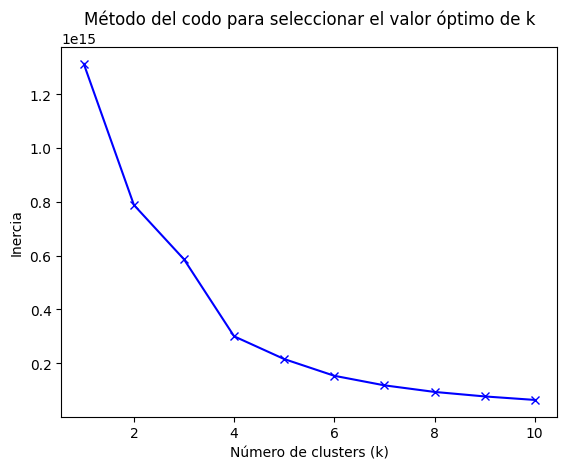

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Supongamos que 'spotify' es tu DataFrame original

# Lista para almacenar la inercia (Suma de los errores al cuadrado)
inertia = []

# Probar diferentes valores de k (por ejemplo, de 1 a 10)
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(spotify[['popularity', 'danceability', 'energy', 'loudness', 
                         'speechiness', 'acousticness', 'instrumentalness', 'liveness', 
                         'valence', 'tempo', 'duration_ms']])  # Seleccionar las columnas necesarias
    inertia.append(kmeans.inertia_)

# Graficar los resultados
plt.plot(k_values, inertia, 'bx-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del codo para seleccionar el valor óptimo de k')
plt.show()